<a href="https://colab.research.google.com/github/get2aakash/DeepLearning_/blob/main/TransferLearning_FineTuningP2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transfer Learning Fine tuning

In [28]:
!nvidia-smi

Fri Jun 11 16:50:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [31]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/3c9b907f628a88ea05e07da518e01deb2e610fb3/extras/helper_functions.py

--2021-06-11 16:53:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/3c9b907f628a88ea05e07da518e01deb2e610fb3/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-06-11 16:53:02 (81.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [39]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

In [34]:
#Use pretrained model from tf.keras.applications https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [36]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2021-06-11 16:56:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 74.125.23.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   156MB/s    in 1.0s    

2021-06-11 16:56:42 (156 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [40]:
unzip_data("10_food_classes_10_percent.zip")

In [41]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [42]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [71]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [46]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [47]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [77]:
#Using Functional API gives flexibility to run models ,non sequentially

#1.Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

#2.Freeze base model (so that underlying pre trained patterns aren't updated during training)
base_model.trainable = False

#3.Create inputs into model
inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

#4.If using ResNet50V2 , we need to normalize input
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5.Pass input  to base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

#6.Average pools the output of base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer") (x)
print(f"Shape after GlobalAveragePooling2D :  {x.shape}")

#7.Create output activation layer
outputs = tf.keras.layers.Dense(10,activation = "softmax" , name = "output_layer") (x)

#8.Combine the model's input and output
model_0  = tf.keras.Model(inputs,outputs)

#9. compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback("transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D :  (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20210611-180443
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 17s 476ms/step - loss: 1.9179 - accuracy: 0.4227 - val_loss: 1.3810 - val_accuracy: 0.6891
Epoch 2/5
24/24 [==============================] - 9s 377ms/step - loss: 1.1556 - accuracy: 0.7480 - val_loss: 0.9219 - val_accuracy: 0.8043
Epoch 3/5
24/24 [==============================] - 9s 377ms/step - loss: 0.8312 - accuracy: 0.8200 - val_loss: 0.7595 - val_accuracy: 0.8125
Epoch 4/5
24/24 [==============================] - 9s 383ms/step - loss: 0.6801 - accuracy: 0.8440 - val_loss: 0.6729 - val_accuracy: 0.8355
Epoch 5/5
24/24 [==============================] - 8s 313ms/step - loss: 0.5821 - accuracy: 0.8627 - val_loss: 0.6281 - val_accuracy: 0.8454


In [74]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 14s 167ms/step - loss: 0.6144 - mse: 0.0279


[0.6143805384635925, 0.027915457263588905]

In [78]:
model_0.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


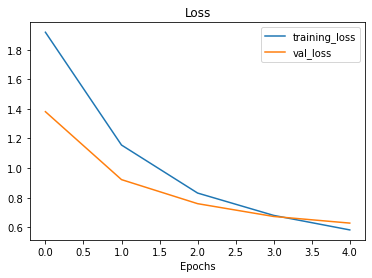

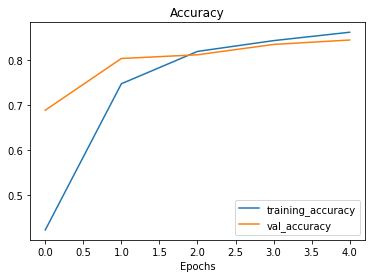

In [79]:
plot_loss_curves(history_10_percent)

Getting feature vector from trained **vector**

In [90]:
input_shape = (1,4,4,3)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor : {input_tensor} \n" )

global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D() (input_tensor)

print(f"global_average_pooled_tensor : {global_average_pooled_tensor} \n")

print(f"input_tensor.shape : {input_tensor.shape} ")
print(f"global_average_pooled_tensor.shape : {global_average_pooled_tensor.shape} ")

Random input tensor : [[[[-1.9948874   1.5386839  -0.1798727 ]
   [ 0.01057413  0.6392652   1.6192093 ]
   [ 0.07532097 -1.9808772   0.6638364 ]
   [-0.7185317  -1.7236719  -1.3388301 ]]

  [[ 0.72827446 -0.82052183 -0.23053153]
   [-1.5689642  -0.63921803  0.9519363 ]
   [-0.625562    0.17479433 -1.1588486 ]
   [ 0.61498773 -1.5861827   0.37630177]]

  [[ 1.2455428  -1.2543411   1.3767717 ]
   [-0.6786727  -0.04404457  0.10146624]
   [-1.3683585   1.0672476  -1.5406656 ]
   [-1.6630338  -0.25086164  1.1611342 ]]

  [[-0.5188195   1.1775132  -0.0187479 ]
   [-0.48949212  0.21842133 -0.8533219 ]
   [ 0.27941912  1.5099884   0.38578966]
   [ 1.206087    0.19348812  0.06351824]]]] 

global_average_pooled_tensor : [[-0.34163222 -0.1112698   0.08619659]] 

input_tensor.shape : (1, 4, 4, 3) 
global_average_pooled_tensor.shape : (1, 3) 
